# Disaster Tweets Topic Classification

In [4]:
# Imports
from collections import Counter
import string
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB

sns.set(style="whitegrid")

Read in the data.

In [5]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Firstly, I will explore the data a little bit by looking at proportions of missing values and looking at a few of the text values from target==0 and target==1.

In [8]:
100*train_df.isnull().sum()[(train_df.isnull().sum() > 0)] / len(train_df)

keyword      0.801261
location    33.272035
dtype: float64

So the location is missing a large amount of data and so won't probably be of use to me. The keyword isn't missing a large proportion of data, it could be useful for the analysis.

In [9]:
train_df[train_df['target'] == 1]['text'].iloc[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [10]:
train_df[train_df['target'] == 0]['text'].iloc[0]

"What's up man?"

## EDA

First I want to check the distribution of the target variable.

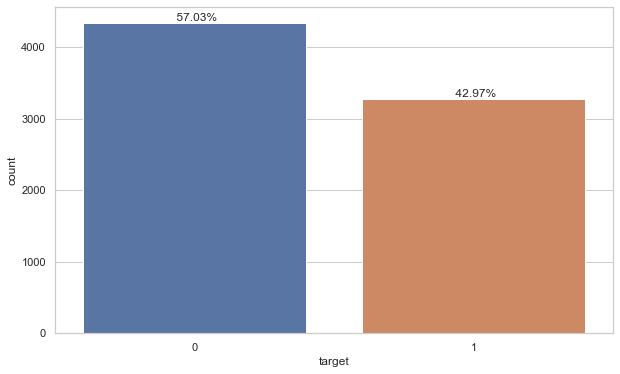

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=train_df['target'])

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{100 * y / len(train_df): .2f}%', (x.mean(), y), ha='center', va='bottom')

The tweets have 57% with topic not disaster related and 43% disaster related. These seem fairly even to me and so when performing cross validation I won't be necessary to stratify.

Let's look for any duplicates in the data.

In [12]:
all(~train_df.duplicated())

True

In [13]:
all(~train_df['text'].duplicated())

False

So in the data we seem to have no complete duplicates but some of the entries have duplicate text.

In [14]:
duplicates = pd.concat(g for _, g in train_df.groupby('text') if len(g) > 1)
duplicates

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1
5620,8018,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated ...,1


We have 179 rows with duplicate text values and it also appears we have some of these duplicates having different target values, indicating these have been manually mislabeled. For this analysis I'm going to remove these to avoid confusion.

In [15]:
train_df = train_df.drop(duplicates.index)

Now I will look for the most common words in the variations of tweets but first I will normalise the data. 

In [16]:
def lowercase_strip_text(text):
    return text.lower().strip()

We also want to remove urls.

In [17]:
def remove_url(text):
    return re.sub(r'http\S+', '', text)

As this is just meant to be a short introduction to NLP, I'm going to ignore the importance of the hashtags and remove them with other punctuation.

In [18]:
def remove_punctuation(text):
    # make translation dict
    table = str.maketrans(dict.fromkeys(string.punctuation))
    
    return text.translate(table)

Now I want to tokenize the words and remove stopwords so I can isolate the most important words in each tweet.

In [19]:
def tokenize_remove_stopwords(text):
    return [w for w in text.split() if w not in set(stopwords.words('english'))]

In [20]:
train_df['cleaned_text'] = train_df['text'].apply(
    lambda x: tokenize_remove_stopwords(
        remove_punctuation(remove_url(lowercase_strip_text(x)))
    )
)

Now I can visualise the most common words in each of the two tweet topic types by using a counter object.

In [21]:
disaster_tweets_counter = Counter()
other_tweets_counter = Counter()

train_df[train_df['target'] == 1]['cleaned_text'].apply(
    lambda x: disaster_tweets_counter.update(x)
)
train_df[train_df['target'] == 0]['cleaned_text'].apply(
    lambda x: other_tweets_counter.update(x)
);

In [22]:
disaster_counts = pd.DataFrame.from_dict(
    disaster_tweets_counter, orient='index', columns=['disaster']
)
other_counts = pd.DataFrame.from_dict(
    other_tweets_counter, orient='index', columns=['other']
)
word_counts = disaster_counts.join(other_counts, how='outer').fillna(0)

Let's have a look at the most common words in each type of tweet and how common they are in both types.

<AxesSubplot:xlabel='value', ylabel='index'>

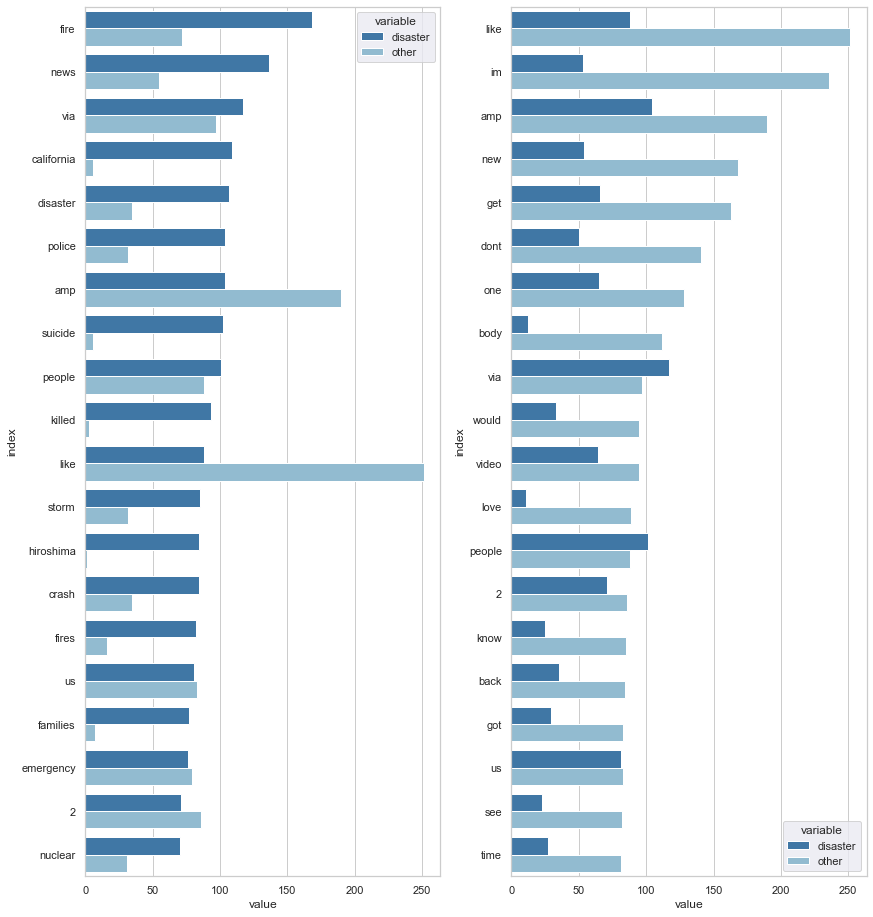

In [23]:
# Put data in right format
melted_disaster = pd.melt(
    word_counts.sort_values('disaster', ascending=False)[:20].reset_index(),
    id_vars=['index'],
    value_vars=['disaster', 'other']
)
melted_other = pd.melt(
    word_counts.sort_values('other', ascending=False)[:20].reset_index(),
    id_vars=['index'],
    value_vars=['disaster', 'other']
)

fig, axes = plt.subplots(1, 2, figsize=(14,16))

sns.set(palette='RdBu_r')
sns.set_color_codes('bright')
sns.barplot(x='value', y='index', hue='variable', data=melted_disaster, ax=axes[0])
sns.barplot(x='value', y='index', hue='variable', data=melted_other,ax=axes[1])

Now let's look for the words with the biggest difference in counts between the two types.

In [24]:
word_counts['difference'] = word_counts['disaster'] - word_counts['other']

word_count_differences = word_counts.reindex(
    word_counts['difference'].abs().sort_values(ascending=False).index
)['difference'][:30]

word_count_differences = word_count_differences.sort_values(ascending=False)

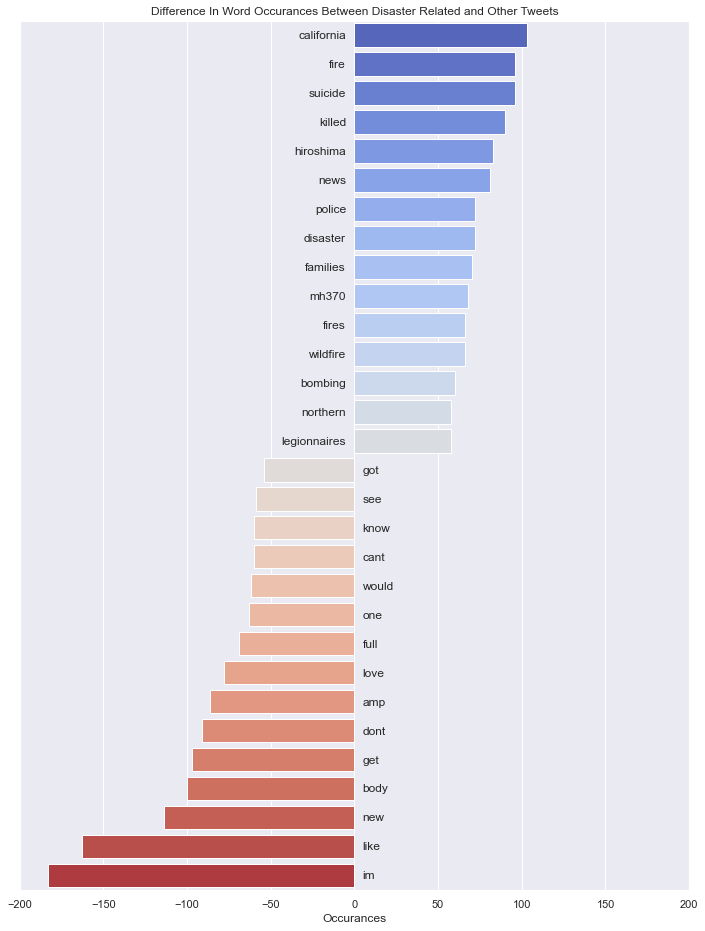

In [25]:
plt.figure(figsize=(12,16))
ax = sns.barplot(x=word_count_differences.values, y=word_count_differences.index, palette='coolwarm')
ax.set(yticks=[])
ax.set(xlim=(-200, 200))
plt.title('Difference In Word Occurances Between Disaster Related and Other Tweets')
plt.xlabel('Occurances')

for p, tick in zip(ax.patches, word_count_differences.index):
    value = p.get_bbox().get_points()[1,0]
    y = p.get_bbox().get_points()[:,1]
    
    if value > 0:
        ax.annotate(f'{tick}', (-5, y.mean()), ha='right', va='center')
    if value < 0:
        ax.annotate(f'{tick}', (5, y.mean()), ha='left', va='center')

## Meta Data

Let's calculate some meta data about the tweets to see if any statistics could help to classify the topic.

#### Word Count

In [22]:
def get_word_count(text):
    cleaned_text = lowercase_strip_text(text)
    cleaned_text = remove_url(text)
    cleaned_text = remove_punctuation(cleaned_text)
    
    return len(cleaned_text.split())

In [23]:
train_df['word_count'] = train_df['text'].apply(get_word_count)
test_df['word_count'] = test_df['text'].apply(get_word_count)

#### Stopword Count

In [24]:
def get_stopword_count(text):
    cleaned_text = lowercase_strip_text(text)
    cleaned_text = remove_punctuation(cleaned_text)
    
    return len([w for w in cleaned_text.split() if w in stopwords.words('english')])

In [25]:
train_df['stopword_count'] = train_df['text'].apply(get_stopword_count)
test_df['stopword_count'] = test_df['text'].apply(get_stopword_count)

#### Average Word Length

In [26]:
def get_avg_word_length(text):
    cleaned_text = lowercase_strip_text(text)
    cleaned_text = remove_url(text)
    cleaned_text = remove_punctuation(cleaned_text)
    cleaned_text = cleaned_text.split()
    
    return sum(map(len, cleaned_text)) / len(cleaned_text)

In [27]:
train_df['avg_word_length'] = train_df['text'].apply(get_avg_word_length)
test_df['avg_word_length'] = test_df['text'].apply(get_avg_word_length)

#### Character Count

In [28]:
train_df['character_count'] = train_df['text'].apply(len)
test_df['character_count'] = test_df['text'].apply(len)

#### Punctuation Count

For a punctuation count I will first want to remove urls, as these can contain large amounts of punctuation this could give an inaccurate count of punctuation in the regular text.

In [29]:
def get_punctuation_count(text):
    cleaned_text = remove_url(text)
    
    return len([c for c in text if c in string.punctuation])

In [30]:
train_df['punctuation_count'] = train_df['text'].apply(get_punctuation_count)
test_df['punctuation_count'] = test_df['text'].apply(get_punctuation_count)

#### Unique Word Count

In [31]:
def get_unique_word_count(text):
    cleaned_text = lowercase_strip_text(text)
    cleaned_text = remove_punctuation(cleaned_text)
    
    return len(set(cleaned_text.split()))

In [32]:
train_df['unique_word_count'] = train_df['text'].apply(get_unique_word_count)
test_df['unique_word_count'] = test_df['text'].apply(get_unique_word_count)

#### Figure/Number Count

In [33]:
train_df['number_count'] = train_df['text'].apply(
    lambda s: len(re.findall('\d+', remove_punctuation(s)))
)
test_df['number_count'] = test_df['text'].apply(
    lambda s: len(re.findall('\d+', remove_punctuation(s)))
)

Now that I have calculated the meta data I can visualise these statistics.

In [34]:
meta_columns = [
    'word_count',
    'stopword_count',
    'avg_word_length',
    'character_count',
    'punctuation_count',
    'unique_word_count',
    'number_count'
]

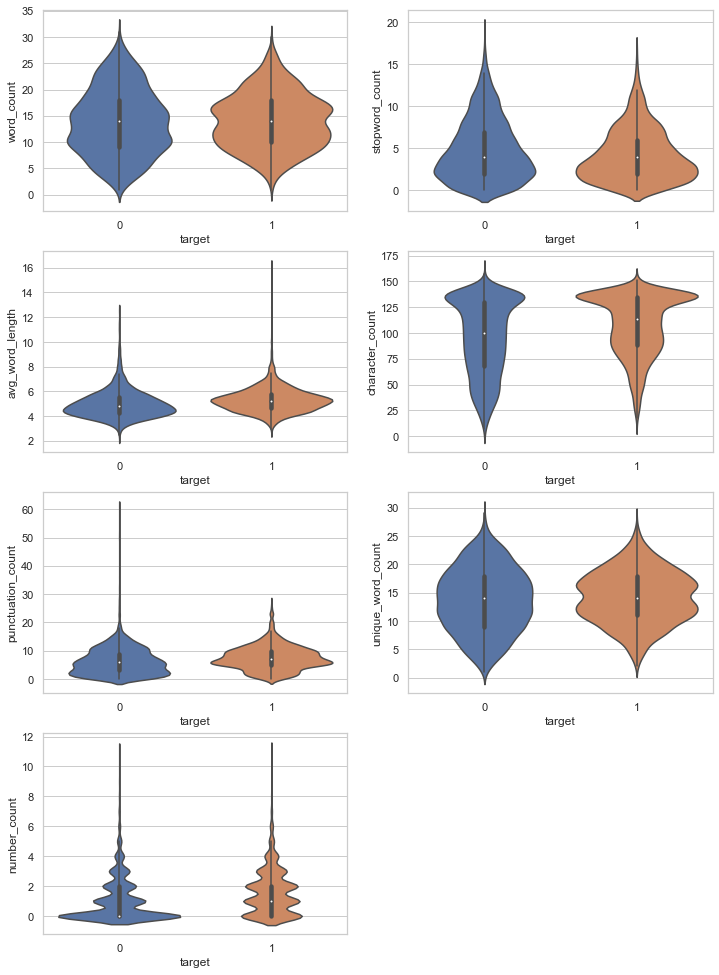

In [37]:
fig, axes = plt.subplots(
    int(np.ceil(len(meta_columns)/2)), 2, 
    figsize=(12, 5*len(meta_columns)//2))

# Remove last axes if odd number of statistics
if len(meta_columns)%2 != 0:
    fig.delaxes(axes[len(meta_columns)//2, 1])

# Plot axes
for ax, statistic in enumerate(meta_columns):
    sns.violinplot(x=train_df['target'], y=train_df[statistic], orient='v', ax=axes[ax//2, ax%2])

There is a small amount of variation in the meta data between the groups but the difference isn't very large. I will test the difference in accuracy when including the variables.

## Modelling

For cleaning the text I want to do the steps I have done above and also stemming. 

In [38]:
stemmer = PorterStemmer()

In [39]:
def clean_text(text):
    cleaned_text = lowercase_strip_text(text)
    cleaned_text = remove_url(cleaned_text)
    cleaned_text = remove_punctuation(cleaned_text)
    cleaned_text = tokenize_remove_stopwords(cleaned_text)
    cleaned_text = map(stemmer.stem, cleaned_text)
    cleaned_text = ' '.join(cleaned_text)
    
    return cleaned_text

In [40]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

Now I want to add the keyword in the data to the cleaned text so that this can be included in the bag of words.

In [75]:
train_df['cleaned_keyword'] = train_df['keyword'].fillna('').apply(lambda s: re.sub('%20', ' ', s))
test_df['cleaned_keyword'] = test_df['keyword'].fillna('').apply(lambda s: re.sub('%20', ' ', s))

In [76]:
train_df['input'] = train_df.apply(
    lambda row: ' '.join([row['cleaned_keyword'], row['cleaned_text']]).strip(), axis=1
)
test_df['input'] = test_df.apply(
    lambda row: ' '.join([row['cleaned_keyword'], row['cleaned_text']]).strip(), axis=1
)

Now I can make a bag of words from the cleaned text to train my model with.

In [77]:
vectorizer = CountVectorizer(ngram_range=(1,2))
train_bow = vectorizer.fit_transform(train_df['input'])
test_bow = vectorizer.transform(test_df['input'])

X_train = np.concatenate((train_bow.toarray(), train_df[meta_columns].values), axis=1)
X_test = np.concatenate((test_bow.toarray(), test_df[meta_columns].values), axis=1)

I'm going to use cross validation with 10 splits to estimate the accuracy of the model.

In [78]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
naive_bayes = MultinomialNB()
cross_val_score(naive_bayes, X_train, train_df['target'], cv=k_fold).mean()

0.8034770763686885

Now I can use this model to predict the topic on the test data.

In [79]:
naive_bayes.fit(X_train, train_df['target'])
predictions = naive_bayes.predict(X_test)

In [98]:
predictions_df = pd.DataFrame([test_df['id'].values, predictions], index=['id', 'target']).T
predictions_df.to_csv('../data/predictions/predictions_1.csv', index=False)